In [1]:
import pandas as pd
import numpy as np


companies_list = pd.read_csv('symbols.csv')
companies_list

,Symbol,Name
0,RELIANCE,Reliance Industries
1,TCS,Tata Consultancy Services
2,HDFCBANK,HDFC Bank
3,ICICIBANK,ICICI Bank
4,BHARTIARTL,Bharti Airtel
...,...,...
815,LGBBROSLTD,LG Balakrishnan & Bros
816,NSIL,Nalwa Sons Investments
817,CARERATING,CARE Ratings
818,MEDIASSIST,Medi Assist Healthcare


In [1]:
import requests
from bs4 import BeautifulSoup
import os
import time

companies = ['RKEC']

In [49]:
if not os.path.exists('screener_pdfs'):
    os.mkdir('screener_pdfs')

# This configuration is necessary for creating a session with bse
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Referer': 'https://www.bseindia.com/',
    'DNT': '1',
    'Upgrade-Insecure-Requests': '1'
})

print("Creating a BSE India session...")
session.get("https://www.bseindia.com/")

for company in companies:
    print(f"\nChecking {company}...")
    url = f'https://www.screener.in/company/{company}/consolidated/'
    
    try:
        page = session.get(url)
        page.raise_for_status()
    except Exception as e:
        print(f"Page load failed: {str(e)}")
        continue

    soup = BeautifulSoup(page.text, 'html.parser')
    pdf_links = soup.find_all('a', class_='concall-link', title="Raw Transcript")
    
    if not pdf_links:
        print(f"No PDF links found for {company}")
        continue
    
    print(f"Successfully found {len(pdf_links)} PDFs for {company}")
    print(f"{'-#-'*30}")
    
    for i, link in enumerate(pdf_links, 1):
        pdf_url = link['href']
        print(f"Attempting PDF {i}: {pdf_url}")
        
        if not pdf_url.endswith('.pdf'):
            print("Skipping non-PDF link")
            continue
            
        try:
            # Add BSE-specific headers
            headers = {
                'Origin': 'https://www.bseindia.com',
                'Sec-Fetch-Dest': 'document',
                'Sec-Fetch-Mode': 'navigate',
                'Sec-Fetch-Site': 'same-origin'
            }
            
            response = session.get(pdf_url, headers=headers, timeout=10)
            
            # Verify successful response
            if response.status_code != 200:
                print(f"Failed with status code: {response.status_code}")
                continue
                
            if 'application/pdf' not in response.headers.get('Content-Type', ''):
                print("Response is not a PDF")
                continue
            try:
                os.mkdir(f'screener_pdfs/{company}')
            except:
                pass

            # Generate filename
            filename = f"screener_pdfs/{company}/concall_{i}.pdf"
            
            # Save PDF
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Successfully saved: {filename}")
            
            # Add delay to avoid rate limiting
            time.sleep(1)
            
        except Exception as e:
            print(f"Download failed: {str(e)}")

print("\n🏁 Done")

Creating a BSE India session...

Checking RKEC...


Successfully found 3 PDFs for RKEC
-#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-
Attempting PDF 1: https://www.rkecprojects.com/_files/ugd/889c9d_1157d6610c414bfeab12aaef39b002b3.pdf
Successfully saved: screener_pdfs/RKEC/concall_1.pdf
Attempting PDF 2: https://www.rkecprojects.com/_files/ugd/889c9d_b72448323dbf4f83b14c8f0c1d321320.pdf
Successfully saved: screener_pdfs/RKEC/concall_2.pdf
Attempting PDF 3: https://www.rkecprojects.com/_files/ugd/889c9d_9930d24c492e4ccf86f986b80f242166.pdf
Successfully saved: screener_pdfs/RKEC/concall_3.pdf

🏁 Done


In [4]:
import pdfplumber
import re

def extract_dialogues_from_pdf(pdf_path, top_margin=70, bottom_margin=100, left_margin=30, right_margin=30):
    """
    Extract dialogues from a PDF, excluding headers and footers by cropping pages. This function also skips the first
    page and handles overlapping text at page breaks.

    Args:
    pdf_path (str): Path to the PDF file.
    top_margin (int): Number of points to exclude from the top of each page.
    bottom_margin (int): Number of points to exclude from the bottom of each page.
    left_margin (int): Number of points to exclude from the left of each page.
    right_margin (int): Number of points to exclude from the right of each page.

    Returns:
    str: A string containing all extracted dialogues, formatted as "Speaker: Dialogue".
    """
    # More lenient regex to capture speaker names including initials or single names
    speaker_pattern = re.compile(r'^([A-Z][a-zA-Z.]+(?: [A-Z][a-zA-Z.]+)*):')

    all_dialogues = ""
    buffer_text = ""  # Buffer to hold the last line of the previous page
    current_dialogue = ""
    current_speaker = None

    with pdfplumber.open(pdf_path) as pdf:
        # Skip the first page
        for page in pdf.pages[1:]:
            page_width, page_height = page.width, page.height

            # Define the bounding box to crop the page
            bbox = (left_margin, bottom_margin, page_width - right_margin, page_height - top_margin)
            cropped_page = page.crop(bbox)
            page_text = cropped_page.extract_text() or ""

            # Combine the text from the buffer and the current page
            combined_text = buffer_text + "\n" + page_text
            lines = combined_text.split("\n")

            # Handle potential duplicate lines at the start of the new page
            if lines and lines[0].strip() == buffer_text.strip():
                lines = lines[1:]

            # Process each line to extract speaker and dialogue
            for line in lines:
                speaker_match = speaker_pattern.match(line.strip())
                if speaker_match:
                    if current_speaker:
                        all_dialogues += f"{current_speaker}: {current_dialogue.strip()}\n"
                    current_speaker = speaker_match.group(1)
                    current_dialogue = line[speaker_match.end():].strip()
                else:
                    current_dialogue += " " + line.strip()

            # Update the buffer with the last line of the current page
            buffer_text = lines[-1] if lines else ""

        # Include the final speaker's dialogue if any remains
        if current_speaker and current_dialogue.strip():
            all_dialogues += f"{current_speaker}: {current_dialogue.strip()}\n"

    return all_dialogues

# # Specify the PDF path and extract dialogues
# pdf_path = f"screener_pdfs/{companies[0]}/concall_1.pdf"
# extracted_dialogues = extract_dialogues_from_pdf(
#     pdf_path,
#     top_margin=70,
#     bottom_margin=100,
#     left_margin=30,
#     right_margin=30
# )

##### Pipeline for extracting the dialogues from each concall.
base_pdf_path = f"screener_pdfs/{companies[0]}/"
for i in range(1,20):
    extracted_dialogues_list = []
    count=0
    try: 
        actual_path = base_pdf_path+ "concall_"+ f"{i}.pdf"
        print(f"Trying to extract the file: {actual_path}")
        extracted_dialogues = extract_dialogues_from_pdf(
            actual_path
            # top_margin=70,
            # bottom_margin=100,
            # left_margin=30,
            # right_margin=30
        )
        extracted_dialogues_list.append(extracted_dialogues)
        count+=1
        print(f"Success count = {count}\n")
    except: 
        # print(f"skipping the file {base_pdf_path+ "concall_"+ f"{i}"} since it doesn't exist")
        continue
    

# print(type(extracted_dialogues)) == string

len(extracted_dialogues_list)


Trying to extract the file: screener_pdfs/UGROCAP/concall_1.pdf


Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_2.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_3.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_4.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_5.pdf
Trying to extract the file: screener_pdfs/UGROCAP/concall_6.pdf
Trying to extract the file: screener_pdfs/UGROCAP/concall_7.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_8.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_9.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_10.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_11.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_12.pdf
Success count = 1

Trying to extract the file: screener_pdfs/UGROCAP/concall_13.pdf
Trying to extract the file: screener_p

0

In [ ]:
import pdfplumber
import re

def extract_dialogues_from_pdf(pdf_path, top_margin=70, bottom_margin=100, left_margin=30, right_margin=30):
    speaker_pattern = re.compile(r'^([A-Z][a-zA-Z.]+(?: [A-Z][a-zA-Z.]+)*):')

    all_dialogues = ""
    buffer_text = ""
    current_dialogue = ""
    current_speaker = None

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages[1:]):  # Skip first page
            print(f"Extracting page {page_num+2} of {pdf_path}")

            # Extract text **without** cropping to check if it's readable
            page_text = page.extract_text()

            if not page_text:
                print(f"Warning: No text extracted from page {page_num+2}")
                continue  # Skip empty pages

            # Apply cropping only if needed
            page_width, page_height = page.width, page.height
            bbox = (left_margin, bottom_margin, page_width - right_margin, page_height - top_margin)
            cropped_page = page.crop(bbox)
            cropped_text = cropped_page.extract_text() or ""

            # If cropping removes text, use full-page text instead
            final_text = cropped_text if cropped_text else page_text
            print(f"Extracted text (post-cropping): {final_text[:500]}...\n{'-'*50}")

            combined_text = buffer_text + "\n" + final_text
            lines = combined_text.split("\n")

            if lines and lines[0].strip() == buffer_text.strip():
                lines = lines[1:]

            for line in lines:
                speaker_match = speaker_pattern.match(line.strip())
                if speaker_match:
                    if current_speaker:
                        all_dialogues += f"{current_speaker}: {current_dialogue.strip()}\n"
                    current_speaker = speaker_match.group(1)
                    current_dialogue = line[speaker_match.end():].strip()
                else:
                    current_dialogue += " " + line.strip()

            buffer_text = lines[-1] if lines else ""

        if current_speaker and current_dialogue.strip():
            all_dialogues += f"{current_speaker}: {current_dialogue.strip()}\n"

    return all_dialogues

# Extract from multiple PDFs
base_pdf_path = f"screener_pdfs/{companies[0]}/"
extracted_dialogues_list = {}
count = 0

for i in range(1, 20):
    actual_path = base_pdf_path + f"concall_{i}.pdf"
    try:
        print(f"Trying to extract from: {actual_path}")
        concall_number = actual_path.split("/")[-1].split(".")[0]
        # Extract dialogues
        extracted_dialogues = extract_dialogues_from_pdf(actual_path)
        extracted_dialogues_list.update({ concall_number : extracted_dialogues})
        count += 1
        print(f"Success count: {count}\n")
    except Exception as e:
        print(f"Skipping {actual_path} due to error: {e}")

print(f"Total successful extractions: {count}")


Trying to extract from: screener_pdfs/RKEC/concall_1.pdf
Extracting page 2 of screener_pdfs/RKEC/concall_1.pdf
Extracted text (post-cropping): Conference Call of RKEC Projects Limited
Event Date / Time : 1st July 2021, 4 PM IST
Event Duration : 55 min 45 secs
Presentation Session
Moderator: Ladies and gentlemen good day and welcome to RKEC
Projects Limited Q4FY21 earnings conference call hosted by Hem Securities Limited.
As a reminder all participants will be in the listen only mode and there will be an
opportunity for you to ask questions after the presentation concludes. Should you need
assistance during the conference call, please s...
--------------------------------------------------
Extracting page 3 of screener_pdfs/RKEC/concall_1.pdf


Extracted text (post-cropping): G. Radhakrishna: Thank you Ms. Astha and Mr. Jayachandran. Good
afternoon ladies and gentlemen. I am Radhakrishna CMD of RKEC Projects Limited. It
is my pleasure to welcome you all to our investor’s conference to discuss the financial
performance of RKEC Projects Limited for the financial year 20-21 and also share with
you our way forward. RKEC Private Limited is one of the leading infra companies which
has 35 years of experience in the business of marine work and bridges. Company has
completed ...
--------------------------------------------------
Extracting page 4 of screener_pdfs/RKEC/concall_1.pdf
Extracted text (post-cropping): and are confident of mitigating it in the next two months’ time. We bring to your kind
notice that we have not removed any of our staff during the pandemic and full salaries
were paid and the directors have sacrificed their salaries to pay them as they are the
pillars and strength of the company.
The profitability of the comp

In [51]:
# print((extracted_dialogues_list[1]))
# print(len(extracted_dialogues_list))
extracted_dialogues_list



{'concall_1': 'Moderator: Ladies and gentlemen good day and welcome to RKEC Projects Limited Q4FY21 earnings conference call hosted by Hem Securities Limited. As a reminder all participants will be in the listen only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing * and then 0 on your touch-screen phones. Please note that this conference is being recorded. I would now like to handover the floor to Ms Astha Jain from Hem Securities Limited. Thank you and over to you ma’am.\nMs. Astha Jain: Thank you Moumita. Good afternoon ladies and gentlemen. Thank you for joining the RKEC Projects Limited Q4 and FY21 earnings conference call. Today we have with us Mr. G. Radhakrishna, Chairman and Managing Director of RKEC Project along with Mr. R. Jayachandran, CFO of the company to discuss the operational and financial performance and to answer all your queri

In [ ]:
def create_dialogue_chunks(extracted_text):
    """
    Converts extracted dialogue text into a list of structured dictionaries, each representing a chunk of dialogue.

    Args:
    extracted_text (str): Extracted dialogues as a single string.

    Returns:
    list: A list of dictionaries, each containing a chunk_id, speaker, and text.
    """
    lines = extracted_text.strip().split("\n")
    chunks = []

    for i, line in enumerate(lines, start=1):
        line = line.strip()
        if not line:
            continue 

        # Attempt to split each line into speaker and dialogue
        parts = line.split(":", 1)
        if len(parts) == 2:
            speaker, dialogue_text = parts
            speaker = speaker.strip()
            dialogue_text = dialogue_text.strip()

            # Store each dialogue as a dictionary
            chunk = {
                "chunk_id": i,
                "speaker": speaker,
                "text": dialogue_text
            }
            chunks.append(chunk)

    return chunks

chunkies = []
chunks_for_each_concall = {}
# Create chunks for each extracted dialogue
for key, dialogue in extracted_dialogues_list.items():
    print(f"Currently processing: {key}")
    chunks_for_each_concall.update({key: create_dialogue_chunks(dialogue)})


print((chunks_for_each_concall))


Currently processing: concall_1
Currently processing: concall_2
Currently processing: concall_3
{'concall_1': [{'chunk_id': 1, 'speaker': 'Moderator', 'text': 'Ladies and gentlemen good day and welcome to RKEC Projects Limited Q4FY21 earnings conference call hosted by Hem Securities Limited. As a reminder all participants will be in the listen only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing * and then 0 on your touch-screen phones. Please note that this conference is being recorded. I would now like to handover the floor to Ms Astha Jain from Hem Securities Limited. Thank you and over to you ma’am.'}, {'chunk_id': 2, 'speaker': 'Ms. Astha Jain', 'text': 'Thank you Moumita. Good afternoon ladies and gentlemen. Thank you for joining the RKEC Projects Limited Q4 and FY21 earnings conference call. Today we have with us Mr. G. Radhakrishna, Chair

In [53]:
with open(f"{companies[0]}_extracted.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Speaker: {chunk['speaker']} \nText: {chunk['text']} \n\n")

In [54]:
# Checking if any chunk is above the 512 token limit
from transformers import AutoTokenizer

# Load the tokenizer for FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

for key, dialogues in chunks_for_each_concall.items():
    print(f"\n\nChecking token limits for: {key}")
    print(f"Total chunks: {len(dialogues)}")
    for chunk in dialogues:
        # Tokenize the text
        tokens = tokenizer(chunk['text'], truncation=True, padding=True, max_length=512, return_tensors="pt")
        token_ids = tokens["input_ids"]
        
        # Check if the token count exceeds 512
        if len(token_ids[0]) > 512:
            print(f"Chunk ID: {chunk['chunk_id']} exceeds 512 tokens.")
            print(f"Token Count: {len(token_ids[0])}")
            print(f"Text: {chunk['text'][:50]}...")  # Print first 50 characters of the text
        else:
            print(f"Chunk ID: {chunk['chunk_id']} is within limits.")
            print(f"Token Count: {len(token_ids[0])}")





Checking token limits for: concall_1
Total chunks: 105
Chunk ID: 1 is within limits.
Token Count: 121
Chunk ID: 2 is within limits.
Token Count: 121
Chunk ID: 3 is within limits.
Token Count: 337
Chunk ID: 4 is within limits.
Token Count: 512
Chunk ID: 5 is within limits.
Token Count: 109
Chunk ID: 6 is within limits.
Token Count: 5
Chunk ID: 7 is within limits.
Token Count: 34
Chunk ID: 8 is within limits.
Token Count: 4
Chunk ID: 9 is within limits.
Token Count: 26
Chunk ID: 10 is within limits.
Token Count: 6
Chunk ID: 11 is within limits.
Token Count: 4
Chunk ID: 12 is within limits.
Token Count: 268
Chunk ID: 13 is within limits.
Token Count: 26
Chunk ID: 14 is within limits.
Token Count: 158
Chunk ID: 15 is within limits.
Token Count: 284
Chunk ID: 16 is within limits.
Token Count: 26
Chunk ID: 17 is within limits.
Token Count: 267
Chunk ID: 18 is within limits.
Token Count: 46
Chunk ID: 19 is within limits.
Token Count: 22
Chunk ID: 20 is within limits.
Token Count: 49
Chunk I

In [56]:
from transformers import pipeline
import torch

# Initialize classifier
temporal_classifier = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli", ## This ones seems to work good, need to try other models.
    device=0 if torch.cuda.is_available() else -1
)

def classify_temporal_events(chunks):
    """Add temporal classification to dialogue chunks."""
    event_labels = ["past event", "present event", "future event"]
    
    for chunk in chunks:
        result = temporal_classifier(
            chunk["text"],
            candidate_labels=event_labels,
            multi_label=False
        )
        chunk["temporal"] = {
            "classification": result["labels"][0],
            "confidence": round(result["scores"][0], 3),
            "scores": dict(zip(result["labels"], result["scores"]))
        }
    
    return chunks

# Classify temporal events for each chunk
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying temporal events for: {key}")
    chunks_for_each_concall[key] = classify_temporal_events(dialogues)
# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_classified.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Speaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Temporal Classification: {chunk['temporal']['classification']} (Confidence: {chunk['temporal']['confidence']})\n")
            f.write("\n")



Device set to use cuda:0


Classifying temporal events for: concall_1
Classifying temporal events for: concall_2
Classifying temporal events for: concall_3


In [ ]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
# import torch
# import statistics

# torch.cuda.empty_cache()


# # Load the pre-trained model and tokenizer
# model = AutoModelForSequenceClassification.from_pretrained('beethogedeon/Modern-FinBERT-large', num_labels=3)
# tokenizer = AutoTokenizer.from_pretrained('answerdotai/ModernBERT-large')

# # Initialize the sentiment analysis pipeline
# sentiment_classifier = pipeline(
#     task="sentiment-analysis",
#     model=model,
#     tokenizer=tokenizer,
#     device=0 if torch.cuda.is_available() else -1
# )

# # Map model labels to understandable sentiments
# label_mapping = {
#     "LABEL_0": "Negative",
#     "LABEL_1": "Neutral",
#     "LABEL_2": "Positive"
# }

# # Normalize scores between -1 (Negative) to 1 (Positive)
# sentiment_scaling = {
#     "Negative": -1,
#     "Neutral": 0,
#     "Positive": 1
# }

# def classify_sentiment(chunks):
#     """Add sentiment classification to dialogue chunks."""
#     for chunk in chunks:
#         result = sentiment_classifier(chunk["text"])[0]  # Get first result
#         sentiment = label_mapping.get(result["label"], "Neutral")  # Map to readable label
#         confidence = round(result["score"], 3)
        
#         chunk["sentiment"] = {
#             "classification": sentiment,
#             "confidence": confidence,
#             "normalized_score": sentiment_scaling[sentiment] * confidence
#         }
    
#     return chunks

# def compute_overall_sentiment(chunks):
#     """Compute overall sentiment based on all chunk sentiments."""
#     scores = [chunk["sentiment"]["normalized_score"] for chunk in chunks if "sentiment" in chunk]
    
#     if scores:
#         avg_score = statistics.mean(scores)
#         overall_sentiment = (
#             "Positive" if avg_score > 0.2 else
#             "Negative" if avg_score < -0.2 else
#             "Neutral"
#         )
#     else:
#         overall_sentiment = "Neutral"
    
#     return {
#         "overall_sentiment": overall_sentiment,
#         "average_score": round(avg_score, 3) if scores else None
#     }

# # Perform sentiment classification on extracted chunks
# for chunks in chunkies:
#     senti = classify_sentiment(chunks)
#     for chunk in senti:
#         print(f"{chunk['speaker']}: {chunk['text']}")
#         print(f"→ Sentiments: {chunk['sentiment']['classification']} ({chunk['sentiment']['confidence']})")
#         print("-"*50)
#     # print(senti)




# # # Store overall sentiment for each PDF
# # overall_sentiments = [compute_overall_sentiment(chunks) for chunks in chunkies]

# # # Print sample output
# # print(overall_sentiments)


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0


MANAGEMENT: MR. SHACHINDRA NATH – FOUNDER AND MANAGING DIRECTOR MR. AMIT MANDE – CHIEF REVENUE OFFICER MR. ANUJ PANDEY – CHIEF RISK OFFICER MR. KISHORE LODHA – CHIEF FINANCIAL OFFICER MR. SHARAD AGARWAL – CHIEF OPERATING AND TECHNOLOGY OFFICER
→ Sentiments: Neutral (1.0)
--------------------------------------------------
MODERATOR: MR. AMAN VISHWAKARMA – PHILLIPCAPITAL (INDIA) PRIVATE LIMITED
→ Sentiments: Neutral (1.0)
--------------------------------------------------
Moderator: Ladies and gentlemen, good day and welcome to the UGRO Capital Limited Q3FY25 and 9MFY25 Earnings Conference Call hosted by PhillipCapital. As a reminder, all participants’ lines will remain in the listen-only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal the operator by pressing ‘*’ then ‘0’ on your touchtone phone. Please note that this conference is being recorded. I now hand the conferen

In [ ]:
# from transformers import pipeline
# import torch

# # Initialize sentiment classifier
# sentiment_classifier = pipeline(
#     task="sentiment-analysis",
#     model="TheFinAI/finma-7b-nlp",
#     device=0 if torch.cuda.is_available() else -1
# )

# def chunk_text(text, max_tokens=510):
#     """Splits text into chunks of a specified maximum token length."""
#     words = text.split()
#     chunks = []
#     current_chunk = []
#     current_length = 0

#     for word in words:
#         current_length += len(word) + 1  # +1 for the space
#         if current_length > max_tokens:
#             chunks.append(' '.join(current_chunk))
#             current_chunk = [word]
#             current_length = len(word) + 1
#         else:
#             current_chunk.append(word)

#     if current_chunk:
#         chunks.append(' '.join(current_chunk))

#     return chunks

# def classify_sentiment(text):
#     """Classify sentiment of the given text, handling long inputs by chunking."""
#     chunks = chunk_text(text)
#     sentiments = []

#     for chunk in chunks:
#         result = sentiment_classifier(chunk)[0]
#         sentiments.append({
#             "text": chunk,
#             "label": result["label"],
#             "score": result["score"]
#         })

#     return sentiments

# # Example usage
# text = "Your long financial document text goes here..."
# sentiment_results = classify_sentiment(text)

# for result in sentiment_results:
#     print(f"Text: {result['text']}\nSentiment: {result['label']} (Score: {result['score']})\n")


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Text: Your long financial document text goes here...
Sentiment: neutral (Score: 0.9298750162124634)



In [57]:
from transformers import pipeline

# Load FinBERT model for financial sentiment analysis
sentiment_pipeline = pipeline("text-classification", model="yiyanghkust/finbert-tone", truncation=True,  # Add this line
                             max_length=512)

# Applying the model to each chunk
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying sentiments for: {key}")
    for chunk in dialogues:
        # print(chunk)
        # print(f"Text: {chunk['text']}")
        # Check if the text is empty
        if not chunk["text"].strip():
            print("Empty text, skipping...")
            continue
        # Classify sentiment
        result = sentiment_pipeline(chunk["text"])[0]
        # print(type(result))
        # print(result)
        chunk["sentiment"] = {
            "classification": result["label"],
            "confidence": round(result["score"], 3)
        }
        print(f"Speaker: {chunk['speaker']}")
        print(f"Text: {chunk['text']}")
        print(f"Sentiment: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})")
        print("-" * 50)
# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_sentiment.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Speaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Sentiment Classification: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})\n")
            f.write("\n")


Device set to use cuda:0


Classifying sentiments for: concall_1
Speaker: Moderator
Text: Ladies and gentlemen good day and welcome to RKEC Projects Limited Q4FY21 earnings conference call hosted by Hem Securities Limited. As a reminder all participants will be in the listen only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing * and then 0 on your touch-screen phones. Please note that this conference is being recorded. I would now like to handover the floor to Ms Astha Jain from Hem Securities Limited. Thank you and over to you ma’am.
Sentiment: Neutral (Confidence: 1.0)
--------------------------------------------------
Speaker: Ms. Astha Jain
Text: Thank you Moumita. Good afternoon ladies and gentlemen. Thank you for joining the RKEC Projects Limited Q4 and FY21 earnings conference call. Today we have with us Mr. G. Radhakrishna, Chairman and Managing Director of RKEC Pr

In [58]:
# Now saving the final combined temoporal and sentiment scores in a text file
with open("UGROCAP_extracted_temporal_and_sentiment.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Speaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Temporal Classification: {chunk['temporal']['classification']} (Confidence: {chunk['temporal']['confidence']})\n")
            f.write(f"Sentiment Classification: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})\n")
            f.write("\n")

In [59]:
#Assigning the final combined sentiment score for the entire transcript
import statistics
import numpy as np
def compute_overall_sentiment(chunks):
    """Compute overall sentiment based on all chunk sentiments."""
    scores = [chunk["sentiment"]["confidence"] for chunk in chunks if "sentiment" in chunk]
    
    if scores:
        avg_score = statistics.mean(scores)
        overall_sentiment = (
            "Positive" if avg_score > 0.2 else
            "Negative" if avg_score < -0.2 else
            "Neutral"
        )
    else:
        overall_sentiment = "Neutral"
    
    return {
        "overall_sentiment": overall_sentiment,
        "average_score": round(avg_score, 3) if scores else None
    }
# Perform sentiment classification on extracted chunks
overall_sentiments = {}
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying overall sentiment for: {key}")
    overall_sentiment = compute_overall_sentiment(dialogues)
    overall_sentiments[key] = overall_sentiment
    print(f"Overall Sentiment: {overall_sentiment['overall_sentiment']} (Average Score: {overall_sentiment['average_score']})")

Classifying overall sentiment for: concall_1
Overall Sentiment: Positive (Average Score: 0.96)
Classifying overall sentiment for: concall_2
Overall Sentiment: Positive (Average Score: 0.992)
Classifying overall sentiment for: concall_3
Overall Sentiment: Positive (Average Score: 0.978)


## Final Script for the extraction of the Data

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import time

companies = ['RELAXO']

In [9]:
if not os.path.exists('screener_pdfs'):
    os.mkdir('screener_pdfs')

# This configuration is necessary for creating a session with bse
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Referer': 'https://www.bseindia.com/',
    'DNT': '1',
    'Upgrade-Insecure-Requests': '1'
})

print("Creating a BSE India session...")
session.get("https://www.bseindia.com/")

for company in companies:
    print(f"\nChecking {company}...")
    url = f'https://www.screener.in/company/{company}/consolidated/'
    
    try:
        page = session.get(url)
        page.raise_for_status()
    except Exception as e:
        print(f"Page load failed: {str(e)}")
        continue

    soup = BeautifulSoup(page.text, 'html.parser')
    pdf_links = soup.find_all('a', class_='concall-link', title="Raw Transcript")
    
    if not pdf_links:
        print(f"No PDF links found for {company}")
        continue
    
    print(f"Successfully found {len(pdf_links)} PDFs for {company}")
    print(f"{'-#-'*30}")
    
    for i, link in enumerate(pdf_links, 1):
        pdf_url = link['href']
        print(f"Attempting PDF {i}: {pdf_url}")
        
        if not pdf_url.endswith('.pdf'):
            print("Skipping non-PDF link")
            continue
            
        try:
            # Add BSE-specific headers
            headers = {
                'Origin': 'https://www.bseindia.com',
                'Sec-Fetch-Dest': 'document',
                'Sec-Fetch-Mode': 'navigate',
                'Sec-Fetch-Site': 'same-origin'
            }
            
            response = session.get(pdf_url, headers=headers, timeout=10)
            
            # Verify successful response
            if response.status_code != 200:
                print(f"Failed with status code: {response.status_code}")
                continue
                
            if 'application/pdf' not in response.headers.get('Content-Type', ''):
                print("Response is not a PDF")
                continue
            try:
                os.mkdir(f'screener_pdfs/{company}')
            except:
                pass

            # Generate filename
            filename = f"screener_pdfs/{company}/concall_{i}.pdf"
            
            # Save PDF
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Successfully saved: {filename}")
            
            # Add delay to avoid rate limiting
            time.sleep(1)
            
        except Exception as e:
            print(f"Download failed: {str(e)}")

print("\n🏁 Done")

Creating a BSE India session...

Checking RELAXO...


Successfully found 16 PDFs for RELAXO
-#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-
Attempting PDF 1: https://www.bseindia.com/stockinfo/AnnPdfOpen.aspx?Pname=d2499699-e734-4ecc-aa04-b9d9ec0ae45e.pdf
Successfully saved: screener_pdfs/RELAXO/concall_1.pdf
Attempting PDF 2: https://www.bseindia.com/stockinfo/AnnPdfOpen.aspx?Pname=4f8198e9-f8e1-413c-85a5-63231b4b53c4.pdf
Successfully saved: screener_pdfs/RELAXO/concall_2.pdf
Attempting PDF 3: https://www.bseindia.com/stockinfo/AnnPdfOpen.aspx?Pname=03337285-94c8-4e85-978d-49a9cc390ceb.pdf
Successfully saved: screener_pdfs/RELAXO/concall_3.pdf
Attempting PDF 4: https://dxkvlfvncvqr8.cloudfront.net/media/file/pdf/download_file/investors-meet-03-11-2023-1698665206.pdf
Download failed: HTTPSConnectionPool(host='dxkvlfvncvqr8.cloudfront.net', port=443): Max retries exceeded with url: /media/file/pdf/download_file/investors-meet-03-11-2023-1698665206.pdf (Caused by NameResolutionError("<urllib3.conne

In [ ]:
import pdfplumber
import re
import ollama

# Speaker classification function using DeepSeek-V2
def classify_speaker(speaker_name, dialogue_text):
    prompt = f"""
    Given the name of a speaker and their spoken text from an earnings call transcript, classify them into one of the following roles:
    - Company Official (CEO, CFO, Executive)
    - Analyst
    - Moderator
    - Investor

    Provide only the role name. No explanations.

    Speaker: {speaker_name}
    Text: {dialogue_text}
    Role:
    """

    response = ollama.chat(model="llama3.1:latest", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].strip()

# Function to extract and structure dialogues from PDF
def extract_dialogues_from_pdf(pdf_path, top_margin=70, bottom_margin=100, left_margin=30, right_margin=30):
    speaker_pattern = re.compile(r'^([A-Z][a-zA-Z.]+(?: [A-Z][a-zA-Z.]+)*):')

    all_chunks = []
    current_speaker = None
    current_dialogue = ""

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages[1:]):  # Skip first page
            print(f"Extracting page {page_num+2} of {pdf_path}")

            # Extract text without cropping first
            page_text = page.extract_text()
            if not page_text:
                print(f"Warning: No text extracted from page {page_num+2}")
                continue  

            # Crop the page and extract again
            bbox = (left_margin, bottom_margin, page.width - right_margin, page.height - top_margin)
            cropped_page = page.crop(bbox)
            cropped_text = cropped_page.extract_text() or page_text

            lines = cropped_text.split("\n")

            for line in lines:
                speaker_match = speaker_pattern.match(line.strip())
                if speaker_match:
                    if current_speaker:
                        role = classify_speaker(current_speaker, current_dialogue)
                        all_chunks.append({
                            "chunk_id": len(all_chunks) + 1,
                            "speaker": current_speaker,
                            "role": role,
                            "text": current_dialogue.strip()
                        })
                    
                    current_speaker = speaker_match.group(1)
                    current_dialogue = line[speaker_match.end():].strip()
                else:
                    current_dialogue += " " + line.strip()

        if current_speaker and current_dialogue.strip():
            role = classify_speaker(current_speaker, current_dialogue)
            all_chunks.append({
                "chunk_id": len(all_chunks) + 1,
                "speaker": current_speaker,
                "role": role,
                "text": current_dialogue.strip()
            })

    return all_chunks

# Extract from multiple PDFs
base_pdf_path = f"screener_pdfs/{companies[0]}/"
chunks_for_each_concall = {}

for i in range(1, 20):
    pdf_path = base_pdf_path + f"concall_{i}.pdf"
    try:
        print(f"Processing: {pdf_path}")
        extracted_chunks = extract_dialogues_from_pdf(pdf_path)
        chunks_for_each_concall[f"concall_{i}"] = extracted_chunks
        print(f"Success: {pdf_path}\n")
    except Exception as e:
        print(f"Skipping {pdf_path} due to error: {e}")

print("Final Output:", chunks_for_each_concall)

# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_classified_with_roles.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Chunk_id:{chunk['chunk_id']} \nSpeaker: {chunk['speaker']} \nRole: {chunk['role']} \nText: {chunk['text']} \n")
            f.write("\n")


Processing: screener_pdfs/RELAXO/concall_1.pdf
Extracting page 2 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 3 of screener_pdfs/RELAXO/concall_1.pdf


Extracting page 4 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 5 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 6 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 7 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 8 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 9 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 10 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 11 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 12 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 13 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 14 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 15 of screener_pdfs/RELAXO/concall_1.pdf
Extracting page 16 of screener_pdfs/RELAXO/concall_1.pdf
Success: screener_pdfs/RELAXO/concall_1.pdf

Processing: screener_pdfs/RELAXO/concall_2.pdf
Extracting page 2 of screener_pdfs/RELAXO/concall_2.pdf
Extracting page 3 of screener_pdfs/RELAXO/concall_2.pdf
Extracting page 4 of screener_pdfs/RELAXO/concall_2.pdf
Extra

In [17]:
chunks_for_each_concall

{'concall_1': [{'chunk_id': 1,
   'speaker': 'MANAGEMENT',
   'role': 'Company Official',
   'text': 'MR. RAMESH KUMAR DUA CHAIRMAN AND MANAGING DIRECTOR MR. GAURAV KUMAAR DUA WHOLE TIME DIRECTOR MR. SUSHIL BATRA EXECUTIVE DIRECTOR & CHIEF FINANCIAL OFFICER MR. RITESH DUA EXECUTIVE VICE PRESIDENT, FINANCE MR. ANKIT JAIN COMPANY SECRETARY & COMPLIANCE OFFICER'},
  {'chunk_id': 2,
   'speaker': 'MODERATOR',
   'role': 'Moderator',
   'text': 'MR. SAMEER GUPTA IIFL SECURITIES LIMITED Relaxo Footwears Limited, hosted by IIFL Securities Limited. As a reminder, all participant lines will be in the listen-only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing star then zero on your touchtone phone. Please note that this conference is being recorded. I now hand the conference over to Mr. Sameer Gupta from IIFL Securities Limited. Thank you, and over to you

In [18]:
from transformers import pipeline
import torch

# Initialize classifier
temporal_classifier = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli", ## This ones seems to work good, need to try other models.
    device=0 if torch.cuda.is_available() else -1
)

def classify_temporal_events(chunks):
    """Add temporal classification to dialogue chunks."""
    event_labels = ["past event", "present event", "future event"]
    
    for chunk in chunks:
        result = temporal_classifier(
            chunk["text"],
            candidate_labels=event_labels,
            multi_label=False
        )
        chunk["temporal"] = {
            "classification": result["labels"][0],
            "confidence": round(result["scores"][0], 3),
            "scores": dict(zip(result["labels"], result["scores"]))
        }
    
    return chunks

# Classify temporal events for each chunk
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying temporal events for: {key}")
    chunks_for_each_concall[key] = classify_temporal_events(dialogues)
# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_classified.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Chunk_id:{chunk['chunk_id']} \nSpeaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Temporal Classification: {chunk['temporal']['classification']} (Confidence: {chunk['temporal']['confidence']})\n")
            f.write("\n")



Device set to use cuda:0


Classifying temporal events for: concall_1


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Classifying temporal events for: concall_2


Classifying temporal events for: concall_3
Classifying temporal events for: concall_5
Classifying temporal events for: concall_6
Classifying temporal events for: concall_7
Classifying temporal events for: concall_8
Classifying temporal events for: concall_9
Classifying temporal events for: concall_10
Classifying temporal events for: concall_12
Classifying temporal events for: concall_14
Classifying temporal events for: concall_15


In [19]:
from transformers import pipeline

# Load A financial sentiment classifyer model for financial sentiment analysis. Currently using distilroberta. Earlier used -->  yiyanghkust/finbert-tone
sentiment_pipeline = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", truncation=True,  # Add this line
                             max_length=512)

# Applying the model to each chunk
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying sentiments for: {key}")
    for chunk in dialogues:
        # print(chunk)
        # print(f"Text: {chunk['text']}")
        # Check if the text is empty
        if not chunk["text"].strip():
            print("Empty text, skipping...")
            continue
        # Classify sentiment
        result = sentiment_pipeline(chunk["text"])[0]
        # print(type(result))
        # print(result)
        chunk["sentiment"] = {
            "classification": result["label"],
            "confidence": round(result["score"], 3)
        }
        print(f"Speaker: {chunk['speaker']}")
        print(f"Text: {chunk['text']}")
        print(f"Sentiment: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})")
        print("-" * 50)
# Save the classified chunks to a file
with open(f"{companies[0]}_extracted_sentiment.txt", 'w') as f:
    for key, dialogues in chunks_for_each_concall.items():
        f.write(f"Concall: {key}\n")
        for chunk in dialogues:
            f.write(f"Speaker: {chunk['speaker']} \nText: {chunk['text']} \n")
            f.write(f"Sentiment Classification: {chunk['sentiment']['classification']} (Confidence: {chunk['sentiment']['confidence']})\n")
            f.write("\n")


Device set to use cuda:0


Classifying sentiments for: concall_1
Speaker: MANAGEMENT
Text: MR. RAMESH KUMAR DUA CHAIRMAN AND MANAGING DIRECTOR MR. GAURAV KUMAAR DUA WHOLE TIME DIRECTOR MR. SUSHIL BATRA EXECUTIVE DIRECTOR & CHIEF FINANCIAL OFFICER MR. RITESH DUA EXECUTIVE VICE PRESIDENT, FINANCE MR. ANKIT JAIN COMPANY SECRETARY & COMPLIANCE OFFICER
Sentiment: neutral (Confidence: 1.0)
--------------------------------------------------
Speaker: MODERATOR
Text: MR. SAMEER GUPTA IIFL SECURITIES LIMITED Relaxo Footwears Limited, hosted by IIFL Securities Limited. As a reminder, all participant lines will be in the listen-only mode and there will be an opportunity for you to ask questions after the presentation concludes. Should you need assistance during the conference call, please signal an operator by pressing star then zero on your touchtone phone. Please note that this conference is being recorded. I now hand the conference over to Mr. Sameer Gupta from IIFL Securities Limited. Thank you, and over to you, sir.
Se

Counting sentiments from pre-classified chunks...
Analyzing sentiments for: concall_1
Analyzing sentiments for: concall_2
Analyzing sentiments for: concall_3
Analyzing sentiments for: concall_5
Analyzing sentiments for: concall_6
Analyzing sentiments for: concall_7
Analyzing sentiments for: concall_8
Analyzing sentiments for: concall_9
Analyzing sentiments for: concall_10
Analyzing sentiments for: concall_12
Analyzing sentiments for: concall_14
Analyzing sentiments for: concall_15

===== ANALYST & INVESTOR SENTIMENT SUMMARY =====
Total Comments: 1396
Positive: 402 (28.8%)
Negative: 138 (9.9%)
Neutral: 856 (61.3%)

Sentiment Trends by Earnings Call:
concall_id  positive  negative  neutral  total  pos_pct  neg_pct
 concall_1        21        14       38     73     28.8     19.2
 concall_2        38         6       82    126     30.2      4.8
 concall_3        35        15       62    112     31.2     13.4
 concall_5        44        16      107    167     26.3      9.6
 concall_6        


===== TOP POSITIVE COMMENTS FROM ANALYSTS/INVESTORS =====
1. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: Temporarily, we can say, yes. But in long term, I think we will be able to gain back the market share. It's because of 2 factors. There is poor footfalls, demand is also subdued and the raw material p...
   Confidence: 1.0

2. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: I think company is taking a lot of steps to improve the margins. On the back-end front, we are working very closely with the manufacturing how to really improve our productivity and add on to our marg...
   Confidence: 1.0

3. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: Sparx, I think we are able to maintain the momentum in Sparx compared to the other open footwear. So I think Sparx should definitely be better off compared to other 2 brands, that is Flite and Bahamas...
   Confidence: 1.0

4. Concall: concall_1, Speaker: Gaurav Kumaar Dua
   Text: Currently, like in October or wha

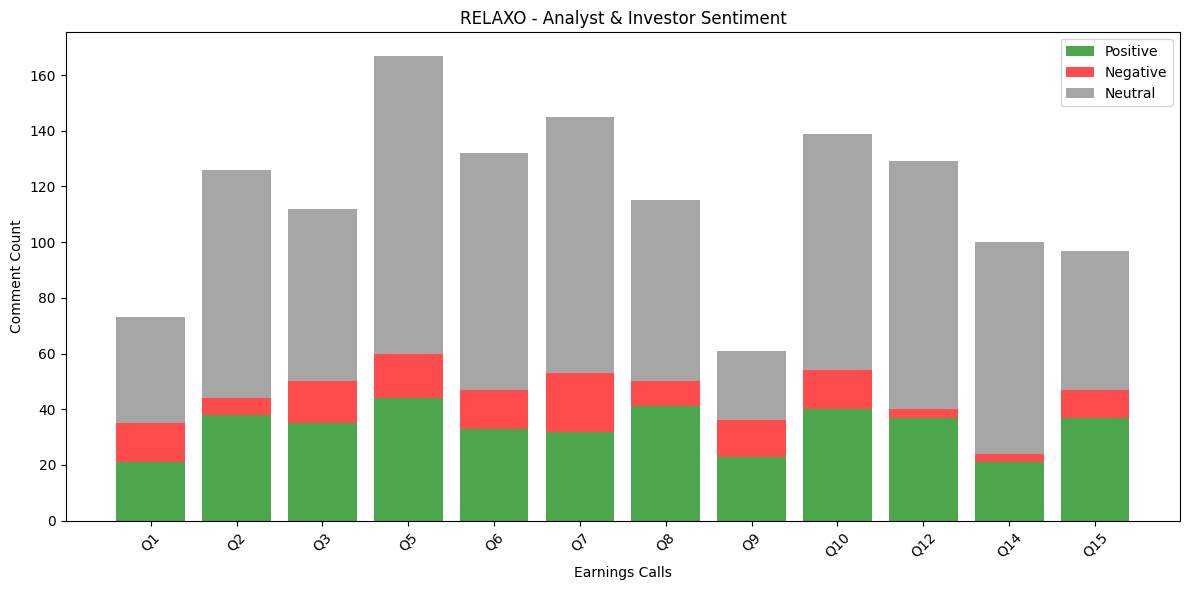

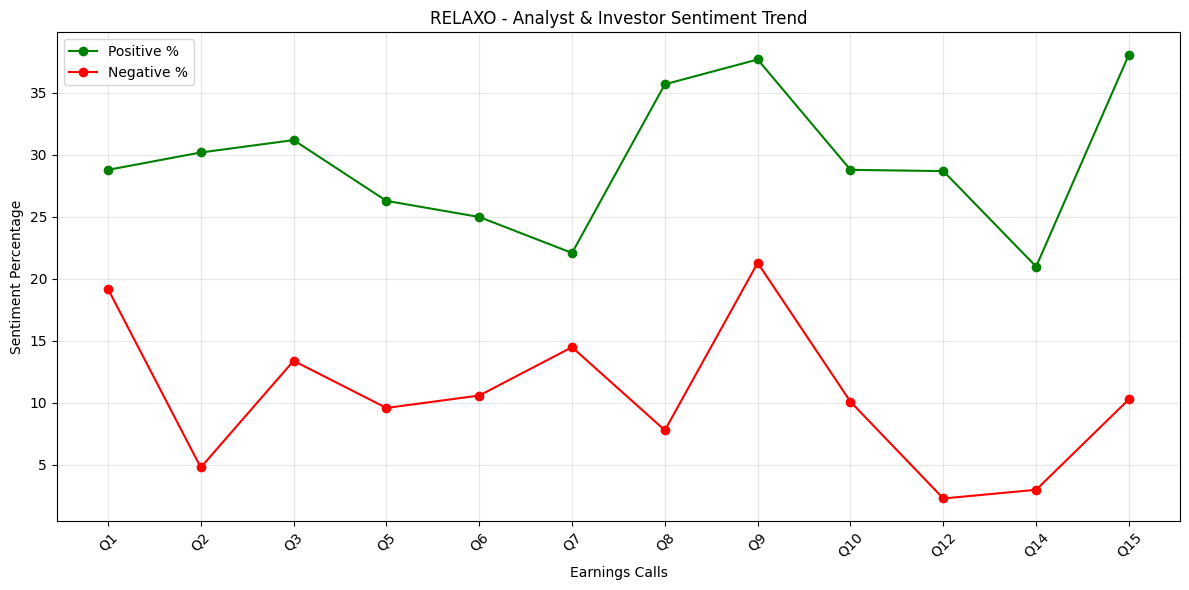

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def count_analyst_investor_sentiment(chunks_for_each_concall):
    """
    Count positive and negative comments by analysts/investors from pre-classified chunks
    """
    # Initialize counters for overall totals
    total_counts = {
        'analyst_investor': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
        'company_official': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
        'moderator': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
        'unknown': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0}
    }
    
    # Track sentiment by concall
    concall_sentiment = {}
    
    # Track highest confidence comments
    top_comments = {
        'positive': [],
        'negative': []
    }
    
    # Process each concall
    for concall_id, chunks in chunks_for_each_concall.items():
        print(f"Analyzing sentiments for: {concall_id}")
        
        # Initialize counters for this concall
        concall_counts = {
            'analyst_investor': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
            'company_official': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
            'moderator': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0},
            'unknown': {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0}
        }
        
        # Process each chunk
        for chunk in chunks:
            # Skip if missing required fields
            if 'role' not in chunk or 'sentiment' not in chunk:
                continue
                
            # Determine role category
            role = chunk['role'].lower()
            if role in ['analyst', 'investor']:
                role_category = 'analyst_investor'
            elif role in ['company official', 'ceo', 'cfo', 'executive']:
                role_category = 'company_official'
            elif role in ['moderator']:
                role_category = 'moderator'
            else:
                role_category = 'unknown'
            
            # Get sentiment classification
            sentiment = chunk['sentiment']['classification']
            confidence = chunk['sentiment']['confidence']
            
            # Normalize sentiment label (in case of different formats)
            if sentiment.lower() in ['positive', 'pos']:
                sentiment_category = 'positive'
            elif sentiment.lower() in ['negative', 'neg']:
                sentiment_category = 'negative'
            else:
                sentiment_category = 'neutral'
                
            # Update counters
            concall_counts[role_category][sentiment_category] += 1
            concall_counts[role_category]['total'] += 1
            
            total_counts[role_category][sentiment_category] += 1
            total_counts[role_category]['total'] += 1
            
            # Track top comments from analysts/investors
            if role_category == 'analyst_investor' and confidence >= 0.7:
                if sentiment_category in ['positive', 'negative']:
                    top_comments[sentiment_category].append({
                        'concall': concall_id,
                        'speaker': chunk['speaker'],
                        'text': chunk['text'][:200] + '...' if len(chunk['text']) > 200 else chunk['text'],
                        'confidence': confidence
                    })
        
        # Store results for this concall
        concall_sentiment[concall_id] = concall_counts
    
    # Sort top comments by confidence
    for sentiment_type in top_comments:
        top_comments[sentiment_type] = sorted(
            top_comments[sentiment_type], 
            key=lambda x: x['confidence'], 
            reverse=True
        )[:5]  # Keep only top 5
    
    return {
        'total_counts': total_counts,
        'concall_sentiment': concall_sentiment,
        'top_comments': top_comments
    }

def generate_sentiment_report(sentiment_counts, companies):
    """
    Generate report and visualizations based on sentiment counts
    """
    total_counts = sentiment_counts['total_counts']
    concall_sentiment = sentiment_counts['concall_sentiment']
    top_comments = sentiment_counts['top_comments']
    
    # Print overall statistics
    print("\n===== ANALYST & INVESTOR SENTIMENT SUMMARY =====")
    ai_counts = total_counts['analyst_investor']
    print(f"Total Comments: {ai_counts['total']}")
    print(f"Positive: {ai_counts['positive']} ({round(ai_counts['positive']/ai_counts['total']*100, 1)}%)")
    print(f"Negative: {ai_counts['negative']} ({round(ai_counts['negative']/ai_counts['total']*100, 1)}%)")
    print(f"Neutral: {ai_counts['neutral']} ({round(ai_counts['neutral']/ai_counts['total']*100, 1)}%)")
    
    # Prepare data for trends analysis
    trend_data = {
        'concall_id': [],
        'positive': [],
        'negative': [],
        'neutral': [],
        'total': [],
        'pos_pct': [],
        'neg_pct': []
    }
    
    for concall_id, counts in concall_sentiment.items():
        ai_counts = counts['analyst_investor']
        if ai_counts['total'] > 0:  # Avoid division by zero
            trend_data['concall_id'].append(concall_id)
            trend_data['positive'].append(ai_counts['positive'])
            trend_data['negative'].append(ai_counts['negative'])
            trend_data['neutral'].append(ai_counts['neutral'])
            trend_data['total'].append(ai_counts['total'])
            trend_data['pos_pct'].append(round(ai_counts['positive']/ai_counts['total']*100, 1))
            trend_data['neg_pct'].append(round(ai_counts['negative']/ai_counts['total']*100, 1))
    
    # Create DataFrame for trends
    trend_df = pd.DataFrame(trend_data)
    trend_df['numeric_id'] = trend_df['concall_id'].str.extract(r'(\d+)').astype(int)  # Extract numeric part
    trend_df = trend_df.sort_values('numeric_id').drop(columns=['numeric_id'])  # Sort by numeric part and drop helper column
    
    print("\nSentiment Trends by Earnings Call:")
    print(trend_df.to_string(index=False))
    
    # Save to CSV
    trend_df.to_csv(f"{companies[0]}_analyst_investor_sentiment_trends.csv", index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = range(len(trend_df))
    
    # Create stacked bar chart
    plt.bar(x, trend_df['positive'], label='Positive', color='green', alpha=0.7)
    plt.bar(x, trend_df['negative'], bottom=trend_df['positive'], 
            label='Negative', color='red', alpha=0.7)
    plt.bar(x, trend_df['neutral'], 
            bottom=[p+n for p,n in zip(trend_df['positive'], trend_df['negative'])],
            label='Neutral', color='gray', alpha=0.7)
    
    plt.xlabel('Earnings Calls')
    plt.ylabel('Comment Count')
    plt.title(f'{companies[0]} - Analyst & Investor Sentiment')
    plt.xticks(x, [call.replace('concall_', 'Q') for call in trend_df['concall_id']], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{companies[0]}_sentiment_distribution.png")
    
    # Create second chart for sentiment ratio trend
    plt.figure(figsize=(12, 6))
    plt.plot(x, trend_df['pos_pct'], 'go-', label='Positive %')
    plt.plot(x, trend_df['neg_pct'], 'ro-', label='Negative %')
    plt.xlabel('Earnings Calls')
    plt.ylabel('Sentiment Percentage')
    plt.title(f'{companies[0]} - Analyst & Investor Sentiment Trend')
    plt.xticks(x, [call.replace('concall_', 'Q') for call in trend_df['concall_id']], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{companies[0]}_sentiment_trend.png")
    
    # Display top comments
    print("\n===== TOP POSITIVE COMMENTS FROM ANALYSTS/INVESTORS =====")
    for i, comment in enumerate(top_comments['positive'], 1):
        print(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}")
        print(f"   Text: {comment['text']}")
        print(f"   Confidence: {comment['confidence']}")
        print()
    
    print("\n===== TOP NEGATIVE COMMENTS FROM ANALYSTS/INVESTORS =====")
    for i, comment in enumerate(top_comments['negative'], 1):
        print(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}")
        print(f"   Text: {comment['text']}")
        print(f"   Confidence: {comment['confidence']}")
        print()
    
    # Save detailed results to a text file
    with open(f"{companies[0]}_analyst_investor_sentiment_report.txt", 'w') as f:
        f.write("===== ANALYST & INVESTOR SENTIMENT ANALYSIS =====\n\n")
        
        # Write summary
        ai_counts = total_counts['analyst_investor']
        f.write("OVERALL STATISTICS\n")
        f.write(f"Total Comments: {ai_counts['total']}\n")
        f.write(f"Positive: {ai_counts['positive']} ({round(ai_counts['positive']/ai_counts['total']*100, 1)}%)\n")
        f.write(f"Negative: {ai_counts['negative']} ({round(ai_counts['negative']/ai_counts['total']*100, 1)}%)\n")
        f.write(f"Neutral: {ai_counts['neutral']} ({round(ai_counts['neutral']/ai_counts['total']*100, 1)}%)\n\n")
        
        # Write per-concall statistics
        f.write("SENTIMENT BY EARNINGS CALL\n")
        f.write(trend_df.to_string(index=False))
        f.write("\n\n")
        
        # Write sample comments
        f.write("TOP POSITIVE COMMENTS\n")
        for i, comment in enumerate(top_comments['positive'], 1):
            f.write(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}\n")
            f.write(f"   Text: {comment['text']}\n")
            f.write(f"   Confidence: {comment['confidence']}\n\n")
        
        f.write("TOP NEGATIVE COMMENTS\n")
        for i, comment in enumerate(top_comments['negative'], 1):
            f.write(f"{i}. Concall: {comment['concall']}, Speaker: {comment['speaker']}\n")
            f.write(f"   Text: {comment['text']}\n")
            f.write(f"   Confidence: {comment['confidence']}\n\n")

    return trend_df

# Run the analysis with pre-classified chunks
print("Counting sentiments from pre-classified chunks...")
sentiment_counts = count_analyst_investor_sentiment(chunks_for_each_concall)

# Generate report and visualizations
trend_df = generate_sentiment_report(sentiment_counts, companies)

print(f"Analysis complete. Results saved to {companies[0]}_analyst_investor_sentiment_report.txt")

In [20]:
# Now assigning the final combined sentiment score for the entire transcript with higher priority to the sentiment of analysts.
import statistics
import numpy as np
def compute_overall_sentiment(chunks):
    """Compute overall sentiment based on all chunk sentiments."""
    # scores = [chunk["sentiment"]["confidence"] for chunk in chunks if "sentiment" in chunk]
    POSITIVE = 1
    NEGATIVE = -3
    NEUTRAL = 0
    Priority_Analyst = 2
    Priority_Investor = 2
    Priority_Company = 0
    Priority_Moderator = 0
    for chunk in chunks:
        if chunk["sentiment"]["classification"] == "POSITIVE":
            chunk["sentiment"]["confidence"] = POSITIVE * chunk["sentiment"]["confidence"]
        elif chunk["sentiment"]["classification"] == "NEGATIVE":
            chunk["sentiment"]["confidence"] = NEGATIVE * chunk["sentiment"]["confidence"]
        elif chunk["sentiment"]["classification"] == "NEUTRAL":
            chunk["sentiment"]["confidence"] = NEUTRAL * chunk["sentiment"]["confidence"]
    
    scores = 0
    for chunk in chunks:
        if chunk["role"] == "Analyst":
            scores += Priority_Analyst * chunk["sentiment"]["confidence"]
        elif chunk["role"] == "Investor":
            scores += Priority_Investor * chunk["sentiment"]["confidence"]
        elif chunk["role"] == "Moderator":
            scores += Priority_Moderator * chunk["sentiment"]["confidence"]
        else:
            scores += Priority_Company * chunk["sentiment"]["confidence"]
    
    if scores:
        avg_score = scores/(len(chunks)+1)
        overall_sentiment = (
            "Positive" if avg_score > 0.6 else
            "Negative" if avg_score < 0.5 else
            "Neutral"
        )
    else:
        overall_sentiment = "Neutral"
    return {
        "overall_sentiment": overall_sentiment,
        "average_score": round(avg_score, 3) if scores else None
    }
# Perform sentiment classification on extracted chunks
overall_sentiments = {}
for key, dialogues in chunks_for_each_concall.items():
    print(f"Classifying overall sentiment for: {key}")
    overall_sentiment = compute_overall_sentiment(dialogues)
    overall_sentiments[key] = overall_sentiment
    print(f"Overall Sentiment: {overall_sentiment['overall_sentiment']} (Average Score: {overall_sentiment['average_score']})")
# # Save the overall sentiments to a file
# with open(f"{companies[0]}_overall_sentiment.txt", 'w') as f:
#     for key, sentiment in overall_sentiments.items():
#         f.write(f"Concall: {key}\n")
#         f.write(f"Overall Sentiment: {sentiment['overall_sentiment']} (Average Score: {sentiment['average_score']})\n")
#         f.write("\n")

Classifying overall sentiment for: concall_1
Overall Sentiment: Positive (Average Score: 1.047)
Classifying overall sentiment for: concall_2
Overall Sentiment: Positive (Average Score: 1.2)
Classifying overall sentiment for: concall_3
Overall Sentiment: Positive (Average Score: 1.243)
Classifying overall sentiment for: concall_5
Overall Sentiment: Positive (Average Score: 1.314)
Classifying overall sentiment for: concall_6
Overall Sentiment: Positive (Average Score: 1.247)
Classifying overall sentiment for: concall_7
Overall Sentiment: Positive (Average Score: 1.378)
Classifying overall sentiment for: concall_8
Overall Sentiment: Positive (Average Score: 1.235)
Classifying overall sentiment for: concall_9
Overall Sentiment: Positive (Average Score: 1.003)
Classifying overall sentiment for: concall_10
Overall Sentiment: Positive (Average Score: 1.314)
Classifying overall sentiment for: concall_12
Overall Sentiment: Positive (Average Score: 1.217)
Classifying overall sentiment for: conca

In [21]:
from transformers import pipeline

# Load BloombergGPT (requires access to the model)
classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# text = "My question is about the 15% drop in margins this quarter. How do you justify this erosion given your earlier guidance?"
# text = "My first question was on the commentary that you made in the press release regarding consumers down-trading to lower price on organized competition and your call to not dilute prices. So how do you see that impacting volumes and market share in the near term?"
text = "Temporarily, we can say, yes. But in long term, I think we will be able to gain back the market share. It's because of 2 factors. There is poor footfalls, demand is also subdued and the raw material prices, all these things, because of multiple factors, they were able to enter. But I think now the wedding season, we are hearing like quarter 3, a lot of weddings are happening, there will be a demand uptake in the market and things will improve."
result = classifier(text)
print(result)  # Output: {'label': 'Negative', 'score': 0.89}

Device set to use cuda:0


[{'label': 'positive', 'score': 0.9996836185455322}]


### Random Testing